In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [77]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [83]:
def transform_features(df):
    
    #remove rows with missing price value
    df = df.dropna(subset=['SalePrice'])
    
    #drop columns with > 5% missing values
    cols_missing = df.isnull().sum()
    drop_missing_cols = cols_missing[(cols_missing > len(df)*0.05)].sort_values()
    print(drop_missing_cols)
    df = df.drop(drop_missing_cols.index, axis=1)
    
    #drop text columns with missing values
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_text_cols = text_missing[text_missing > 0]
    print(drop_missing_text_cols)
    df = df.drop(drop_missing_text_cols.index, axis=1)
    
    #replace numeric columns has missing values with mean
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fix_num_cols = num_missing[num_missing > 0].sort_values()
    replace_value = df[fix_num_cols.index].mean()
    df = df.fillna(replace_value)
    
    #add useful features
    years_since_built = df['Yr Sold'] - df['Year Built']
    negative = years_since_built[years_since_built < 0]
    df['Years Since Built'] = years_since_built
    df.drop(negative.index, axis = 0)

    ## Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    ## Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

In [156]:
def select_features(df):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    numerical_df.head(5)
    # Drop columns with less than 0.4 correlation with SalePrice
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)
    
    
    #numerical columns that should be categorical
    nominal_features = ['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Foundation', 'Heating', 'Central Air']

    # count unique values in each categorical column
    uniqueness_counts = df[nominal_features].apply(lambda col: len(col.value_counts())).sort_values()
    # Drop categorical columns with more than 10 unique values 
    drop_noncat_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_noncat_cols, axis=1)
    print(df.columns)
    
    #check if columns still in df then change to nominal
    for feature in nominal_features:
        if feature in df.columns:
            df[feature] = df[feature].astype(str)


    return df

In [157]:
transform_df = transform_features(df)
transform_df.info()

Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Lot Frontage      490
Fireplace Qu     1422
Fence            2358
Alley            2732
Misc Feature     2824
Pool QC          2917
dtype: int64
Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 59 columns):
MS SubClass          2930 non-null int64
MS Zoning            2930 non-null object
Lot Area             2930 non-null int64
Street               2930 non-null object
Lot Shape            2930 non-null object
Land Contour         2930 non-null object
Utilities            2930 non-null object
Lot Config           2930 non-null object
Land Slope           2930 non-null object
Neighborhood         2930 non-null object
Condition 1          2930 non-null object
Condition 2       

In [158]:
selected_df = select_features(transform_df)


Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'SalePrice', 'Years Since Built'],
      dtype='object')


In [159]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 40 columns):
MS Zoning            2930 non-null object
Street               2930 non-null object
Lot Shape            2930 non-null object
Land Contour         2930 non-null object
Utilities            2930 non-null object
Lot Config           2930 non-null object
Land Slope           2930 non-null object
Neighborhood         2930 non-null object
Condition 1          2930 non-null object
Condition 2          2930 non-null object
Bldg Type            2930 non-null object
House Style          2930 non-null object
Overall Qual         2930 non-null int64
Year Built           2930 non-null int64
Year Remod/Add       2930 non-null int64
Roof Style           2930 non-null object
Roof Matl            2930 non-null object
Exterior 1st         2930 non-null object
Exterior 2nd         2930 non-null object
Mas Vnr Area         2930 non-null float64
Exter Qual           2930 non-null object
Exter Cond   

Some scatterplot

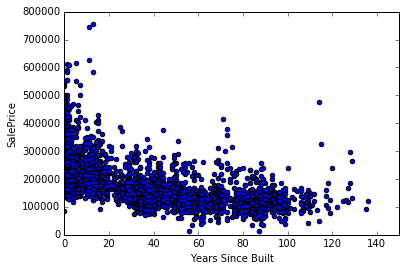

-0.5589068324589404


In [160]:
selected_df.plot.scatter('Years Since Built','SalePrice')
plt.xlim(0, 150)
plt.ylim(0, 800000)
plt.show()
print(selected_df['Years Since Built'].corr(selected_df['SalePrice']))

categorical

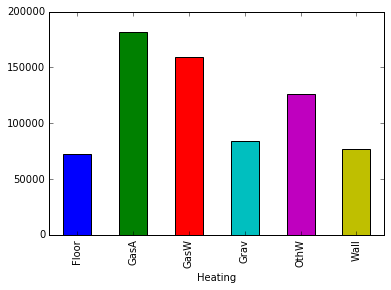

In [162]:
selected_df.groupby('Heating')['SalePrice'].mean().plot(kind='bar')
plt.show()

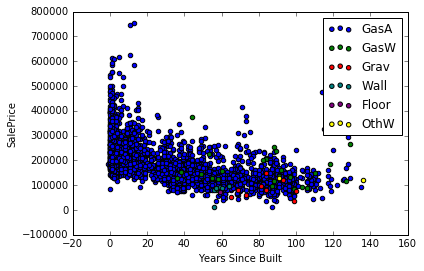

In [165]:
ax=None
colors = ['blue','green','red','teal','purple','yellow']
for i,v in enumerate(selected_df['Heating'].unique()):
    ax = selected_df[selected_df['Heating']==v].plot.scatter('Years Since Built','SalePrice', 
                                                               ax=ax, c=colors[i], label = v)
    
plt.show()

Linear regression

In [120]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [136]:
x = selected_df['Years Since Built'].values.reshape(-1,1)
y = selected_df['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)
lr = LinearRegression()
lr.fit(x_train,y_train)

predict = lr.predict(x_test)
mse = np.sqrt(mean_squared_error(y_test,predict))
print(mse)
print(lr.coef_)
print(lr.intercept_)
print(lr.predict([[2]]))

67426.1196783038
[-1485.47922882]
234322.26309064066
[231351.304633]


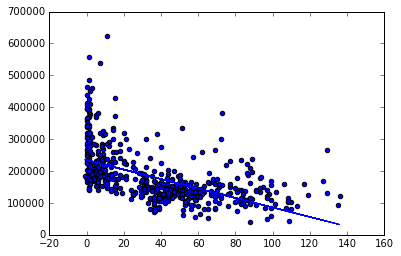

In [130]:
plt.scatter(x_test,y_test)
plt.plot(x_test,predict)

Polynominal regression

In [140]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(x_train,y_train)
predict = pipeline.predict(x_test)

mse = np.sqrt(mean_squared_error(y_test,predict))
print('mean error: ', mse)

score = pipeline.score(x_train,y_train)
print('model determination: ', score)

mean error:  63143.584940390465
model determination:  0.3843614450554883


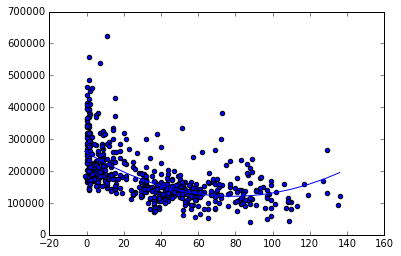

In [141]:
plt.scatter(x_test,y_test)
plt.plot(sorted(x_test),pipeline.predict(sorted(x_test)))

linear regression on categorical data

In [166]:
x = pd.get_dummies(selected_df['Heating'])
y = selected_df['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)
lr = LinearRegression()
lr.fit(x_train,y_train)

predict = lr.predict(x_test)

mse = np.sqrt(mean_squared_error(y_test,predict))
print('mean squared error: ',mse)

score = lr.score(x_train,y_train)
print('model determination: ', score)

mean squared error:  80717.85246820246
model determination:  0.009760384793710997
